In [1]:
import warnings

warnings.filterwarnings('ignore')

## Constructing Circuits 

In this section we will explore building quantum circuits in pytket with the `Circuit` class and introduce some useful circuit primitives.

### Basic Bell circuit

In pytket we can create an instance of the `Circuit` class and add gates sequentially. We can prepare an entangled Bell state using a Hadamard and a CX gate

$$
\begin{equation}
\text{H} = \frac{1}{\sqrt{2}}
\begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}\,, 
\quad
\text{CX} = 
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{pmatrix}
\end{equation}
$$

In [2]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter

bell_circ = Circuit(2, name="Bell")
bell_circ.H(0)
bell_circ.CX(0, 1)
render_circuit_jupyter(bell_circ)

In [3]:
from pytket.extensions.qiskit import AerStateBackend

sv_backend = AerStateBackend()
result_state = sv_backend.run_circuit(bell_circ).get_state()
print("Statevector =", result_state)

Statevector = [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


Compare with the equation below...


$$
\begin{equation}
|\psi \rangle = \frac{1}{\sqrt{2}} \big(|00 \rangle + | 11 \rangle  \big)\,, \qquad \frac{1}{\sqrt{2}} \approx 0.707...
\end{equation}
$$

In [4]:
from pytket.extensions.qiskit import AerBackend

bell_circ.measure_all()
render_circuit_jupyter(bell_circ)

backend = AerBackend()
result = backend.run_circuit(bell_circ, n_shots=1000)
print(result.get_counts())

Counter({(0, 0): 521, (1, 1): 479})


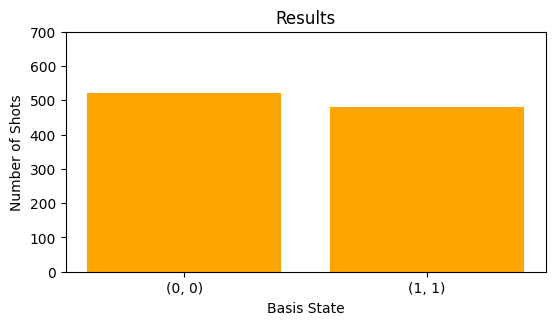

In [5]:
from plotting import plot_results

plot_results(result)

### Other Quantum Gates

* Some gates need to be accessed through the `OpType` enum
* Angles are specified as the number of half turns
* See the docs for all OpTypes - https://cqcl.github.io/tket/pytket/api/optype.html

In [6]:
from pytket import OpType

circ = Circuit(4) # create a 4 qubit circuit

for qubit in range(circ.n_qubits): # Add a Hadamard to every qubit
    circ.H(qubit)
    
circ.Ry(0.25, 1) # Ry gate, angle expressed as no. half turns

circ.add_gate(OpType.CRz, [0.39], [2, 3]) # Controlled SXdg

circ.add_gate(OpType.CCX, [0, 1, 2]) # Toffoli gate

circ.add_gate(OpType.CnRy, [0.7], [0, 1, 2, 3]) # Multi-controlled Ry

render_circuit_jupyter(circ)

## An Interesting Circuit - The Quantum Fourier Transform

As we've heard the Quantum Fourier Transform (QFT) is an important subroutine in several quantum algorithms including Shor's algorithm for factoring

$$
\begin{equation}
U_{\text{QFT}} |j \rangle = \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1} e^{2\pi i j k/ N} |k \rangle \,, \quad i^2 = -1 , \, N=2^n
\end{equation}
$$

We can build the circuit for the $n$ qubit QFT using $n$ Hadamard gates $\frac{n}{2}$ swap gates and $\frac{n(n-1)}{2}$ controlled unitary rotations. 

$$
\begin{equation}
\text{CU1} = 
\begin{pmatrix}
I & 0 \\
0 & \text{U1}
\end{pmatrix}
\,, \quad 
\text{U1} = 
\begin{pmatrix}
1 & 0 \\
0 & e^{i \pi \theta}
\end{pmatrix}
\end{equation}
$$

We will rotate by smaller and smaller angles of $\theta = \frac{1}{2^{n-1}}$ 

In [7]:
# lets build the QFT for three qubits
qft_circ = Circuit(3)

qft_circ.H(0)
qft_circ.add_gate(OpType.CU1 , [0.5], [1, 0])
qft_circ.add_gate(OpType.CU1 , [0.25], [2, 0])

qft_circ.H(1)
qft_circ.add_gate(OpType.CU1 , [0.5], [2, 1])

qft_circ.H(2)

qft_circ.SWAP(0, 2)

render_circuit_jupyter(qft_circ)

The $n$ qubit QFT can be impelemented as follows

In [8]:
def build_qft_circuit(n_qubits: int) -> Circuit:
    circ = Circuit(n_qubits, name="QFT")
    q_counter = 0
    for j in range(n_qubits):
        circ.H(j)
        q_counter += 1
        for k in range(n_qubits - q_counter):
            circ.add_gate(OpType.CU1, 0.5 ** (k + 1), [k + q_counter, q_counter - 1])
        
        circ.add_barrier(list(range(n_qubits))) # barrier prevents gate reordering

    # Add swaps to the end of the qft circuit - makes the unitary nicer
    for i in range(0, n_qubits // 2):
        circ.SWAP(i, n_qubits - i - 1)

    return circ

In [9]:
qft4 = build_qft_circuit(4)

render_circuit_jupyter(qft4)

### Circuit Boxes (I)

* Raw quantum gates are sometimes too low level to see whats going on
* We can wrap up sub circuits into boxes and add them to circuits (useful for subroutines).
* QFT subroutine example below

In [10]:
from pytket.circuit import CircBox

qft4 = build_qft_circuit(4)
qft4box = CircBox(qft4)

circ.add_circbox(qft4box, [0, 1, 2, 3])
render_circuit_jupyter(circ)

### Circuit Boxes (II)

* Often we will need synthesise a quantum circuit to implement a gievn unitary
* Unitary synthesis is supported by TKET (Up to 3 qubits)
* **Fact:** A two qubit unitary can be implemented with at most 3 CX gates

Lets see an example with the Fermionic SWAP or $\text{FSWAP}$ gate

$$
\begin{equation}
\text{FSWAP} =
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0\\
0 & 0 & 0 & -1 
\end{pmatrix}
\end{equation}
$$

In [11]:
from pytket.circuit import Unitary2qBox
import numpy as np

unitary_2q = np.asarray([
                 [1, 0, 0, 0],
                 [0, 0, 1, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, -1]])

u2_box = Unitary2qBox(unitary_2q)

test_circ = Circuit(2)
test_circ.add_unitary2qbox(u2_box, 0, 1)

render_circuit_jupyter(test_circ)

In [12]:
from pytket.passes import DecomposeBoxes

DecomposeBoxes().apply(test_circ) # Decompose the box in place

render_circuit_jupyter(test_circ) # view raw circuit 

### Constructing a Circuit from QASM

* OpenQASM (Open Quantum assembly language provides a low level specification of quantum circuits)
* We Can easily build a circuit from a QASM file (And also export a circuit to QASM)

In [13]:
from pytket.qasm import circuit_from_qasm

qpe_circ = circuit_from_qasm("qpe.qasm")
print("Total number of gates =", qpe_circ.n_gates)
print("#two qubit gates =", qpe_circ.n_2qb_gates())

render_circuit_jupyter(qpe_circ)

Total number of gates = 21
#two qubit gates = 11


## Using Quantum devices and Simulators

In addition to the idealised noiseless simulators we used previously we can also target emulators which try to replicate the constraints and noise of a real quantum computer

In order to give some ideas of quantum compilation we can use a larger Quantum Phase estimation circuit and run it on an IBM Simulator.

**Disclaimer:** Not the most realistic experiment 

Visit https://quantum-computing.ibm.com/ to get an API token. Also see 

Credential saving process below

In [14]:
#from qiskit import IBMQ
#IBMQ.save_account("MyToken", overwrite=True)

#from pytket.extensions.qiskit.backends.config import set_ibmq_config

#set_ibmq_config(ibmq_api_token="MyToken")

In [15]:
from pytket.extensions.qiskit import IBMQEmulatorBackend

qpe5_circ = circuit_from_qasm("qpe5.qasm")
noisy_backend = IBMQEmulatorBackend('ibmq_jakarta')

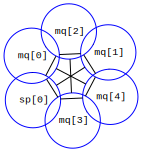

In [16]:
from pytket.utils import Graph

Graph(qpe5_circ).get_qubit_graph()

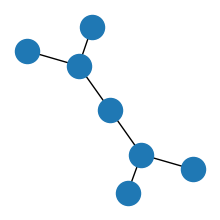

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

coupling_graph = noisy_backend.backend_info.architecture.coupling
G = nx.Graph(coupling_graph)
plt.figure(figsize=(2,2))
nx.draw(G)
plt.show()

In [18]:
compiled_circuit_l0 = noisy_backend.get_compiled_circuit(qpe5_circ, optimisation_level=0)

cx_count = compiled_circuit_l0.n_2qb_gates()
print("How many CX gates do we have?" ,cx_count)

How many CX gates do we have? 136


In [19]:
render_circuit_jupyter(compiled_circuit_l0)


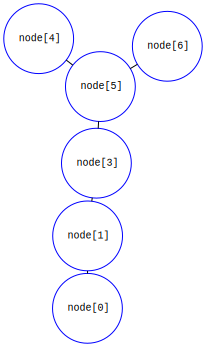

In [20]:
Graph(compiled_circuit_l0).get_qubit_graph()

In [21]:
handlel0 = noisy_backend.process_circuit(compiled_circuit_l0, n_shots=1000)
resultl0 = noisy_backend.get_result(handlel0)

In [22]:
print(resultl0.get_counts().most_common()[0])

((0, 1, 1, 0, 1), 380)


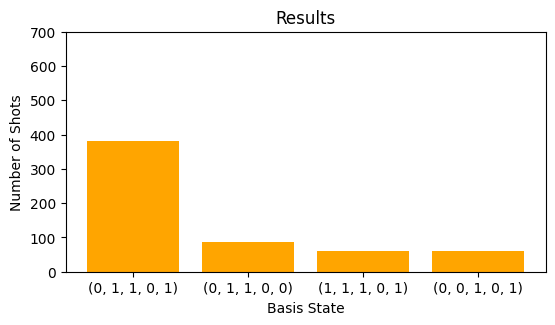

In [23]:
plot_results(resultl0, n_strings=4)

In [24]:
compiled_circuit_l2 = noisy_backend.get_compiled_circuit(qpe5_circ, optimisation_level=2)
cx_count = compiled_circuit_l2.n_gates_of_type(OpType.CX)
print(f"Our optimised circuit has {cx_count} CX gates")

handlel2 = noisy_backend.process_circuit(compiled_circuit_l2, n_shots=1000)
resultl2 = noisy_backend.get_result(handlel2)

Our optimised circuit has 52 CX gates


In [25]:
print(resultl2.get_counts().most_common()[0])

((0, 1, 1, 0, 1), 484)


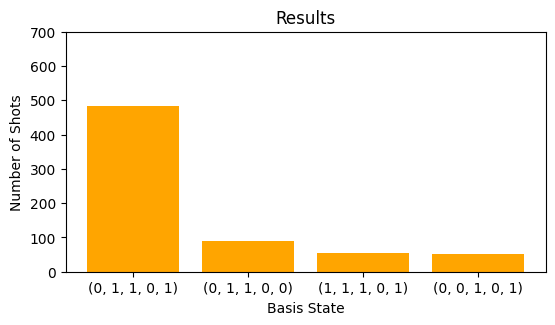

In [26]:
plot_results(resultl2, n_strings=4)

### Switching Backends in pytket

* Researchers may want to explore running their quantum algorithms on different devices
* Uniform `Backend` interface for targeting different devices/simulators
* lets switch to a Cirq simulator. This simulator uses the {PhasedX, Rz, CZ} gatset

In [27]:
from pytket.extensions.cirq import CirqStateSampleBackend

cirq_backend = CirqStateSampleBackend()
compiled_cirq = cirq_backend.get_compiled_circuit(qpe_circ)

render_circuit_jupyter(compiled_cirq)

cirq_result = cirq_backend.run_circuit(compiled_cirq, n_shots=1000)

## Brief section on Optimisation passes

* As we have seen with the phase estimation circuits we can boost the Fidelity of our circuits by reducing the number of gates in our circuit

* Lets try optimising a circuit from quantum chemistry with the general purpose `FullPeepholeOptimise` pass

In [28]:
jw_chem_circ = circuit_from_qasm("H2JordanWignerMapper.qasm")
render_circuit_jupyter(jw_chem_circ)

print("Total gate count =", jw_chem_circ.n_gates)
print("#2 qubit gates =", jw_chem_circ.n_2qb_gates())

Total gate count = 150
#2 qubit gates = 56


In [29]:
from pytket.passes import FullPeepholeOptimise

FullPeepholeOptimise().apply(jw_chem_circ)

render_circuit_jupyter(jw_chem_circ)
print("Total gate count =", jw_chem_circ.n_gates)
print("#2 qubit gates =", jw_chem_circ.n_2qb_gates())

Total gate count = 46
#2 qubit gates = 17


In [30]:
from pytket.passes import auto_rebase_pass

ibm_gateset = {OpType.X, OpType.SX, OpType.Rz, OpType.CX}
ibm_rebase = auto_rebase_pass(ibm_gateset)

ibm_rebase.apply(jw_chem_circ)

True

The `auto_rebase_pass` works well if converting to a well known gateset i.e. one used by a hardware provider like IBM.

Rebases to other univeral sets of 1q and 2q gates can be accomplished with `RebaseCustom`.

We can also compose our own circuit transformations with `SequencePass`.

In [31]:
from pytket.passes import SequencePass

seq_pass = SequencePass([FullPeepholeOptimise(), ibm_rebase])

jw_chem_circ = circuit_from_qasm("H2JordanWignerMapper.qasm")

seq_pass.apply(jw_chem_circ)

render_circuit_jupyter(jw_chem_circ)

### Working with Qiskit, Cirq and other libraries

* TKET supports easy conversion to and from qiskit circuits
* Also supported for (Cirq, pennylane, pyquil and Q# through the extensions)
* **Benefit:** Allows TKET compilation features to be used in conjunction with other tools 

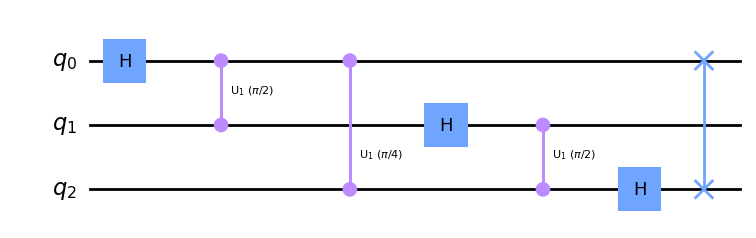

In [32]:
from pytket.extensions.qiskit import tk_to_qiskit #, qiskit_to_tk

qiskit_qc = tk_to_qiskit(qft_circ) 
# use qiskit_to_tk for conversion to TKET

qiskit_qc.draw('mpl', fold=-1)

Lets convert the QFT circuit we built earlier to a Cirq circuit

In [33]:
from pytket.extensions.cirq import tk_to_cirq

cirq_qc = tk_to_cirq(qft_circ)
print(cirq_qc)

                  ┌───────┐
0: ───H───@────────@──────────────────────×───
          │        │                      │
1: ───────@^0.5────┼─────H────@───────────┼───
                   │          │           │
2: ────────────────@^0.25─────@^0.5───H───×───
                  └───────┘


## Summary - What have we learned?

* Overview of TKET and the challenges of running quantum algorithms
* Constructing circuits using the primitives available in pytket
* Running basic simulations of quantum circuits
* How to target different quantum devices with pytket
* Optimising circuits 
* Using qiskit alongside other quantum SDKs


Install using the command 


<p><center> <code> pip install pytket </code> </center>

Useful links
* [API docs](https://cqcl.github.io/tket/pytket/api/)
* [Notebook examples](https://github.com/CQCL/pytket/tree/main/examples)
* [User Manual](https://cqcl.github.io/pytket/manual/manual_intro.html)

Visit the TKET reposiotry -> https://github.com/CQCL/tket 

Open source  contributions welcome! :) 


## Any Questions?

